In [45]:
import os
import shutil
import kagglehub
hsankesara_flickr_image_dataset_path = kagglehub.dataset_download('hsankesara/flickr-image-dataset')
flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')
print('Data source import complete.')

Data source import complete.


In [46]:
import os
print(os.listdir(hsankesara_flickr_image_dataset_path))
print(os.listdir(flickr8k_path))
print(hsankesara_flickr_image_dataset_path)
print(flickr8k_path)

['flickr30k_images']
['captions.txt', 'Images']
/Users/vaishnavikaringala/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1
/Users/vaishnavikaringala/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [47]:
# from google.colab import drive
# import shutil
# import os
# drive.mount('/content/drive')
# save_dir = '/content/drive/My Drive/kaggle_datasets'
# os.makedirs(save_dir, exist_ok=True)
# hsankesara_dataset_source = '/root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1'
# flickr8k_dataset_source = '/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1'
# hsankesara_dataset_dest = os.path.join(save_dir, 'hsankesara_flickr_image_dataset')
# flickr8k_dataset_dest = os.path.join(save_dir, 'flickr8k')
# shutil.move(hsankesara_dataset_source, hsankesara_dataset_dest)
# shutil.move(flickr8k_dataset_source, flickr8k_dataset_dest)
# print('Datasets moved to Google Drive successfully!')
# print(os.listdir(save_dir))


In [48]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [49]:
image_path = '/Users/vaishnavikaringala/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images'

#/Users/vaishnavikaringala/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1

In [50]:
data = pd.read_csv("/Users/vaishnavikaringala/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/captions.txt")
data.head()


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [51]:
import shutil

# Copy the file to the current directory
source = "/Users/vaishnavikaringala/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/captions.txt"
destination = "captions.txt"
shutil.copy(source, destination)

'captions.txt'

In [7]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/Users/vaishnavikaringala/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

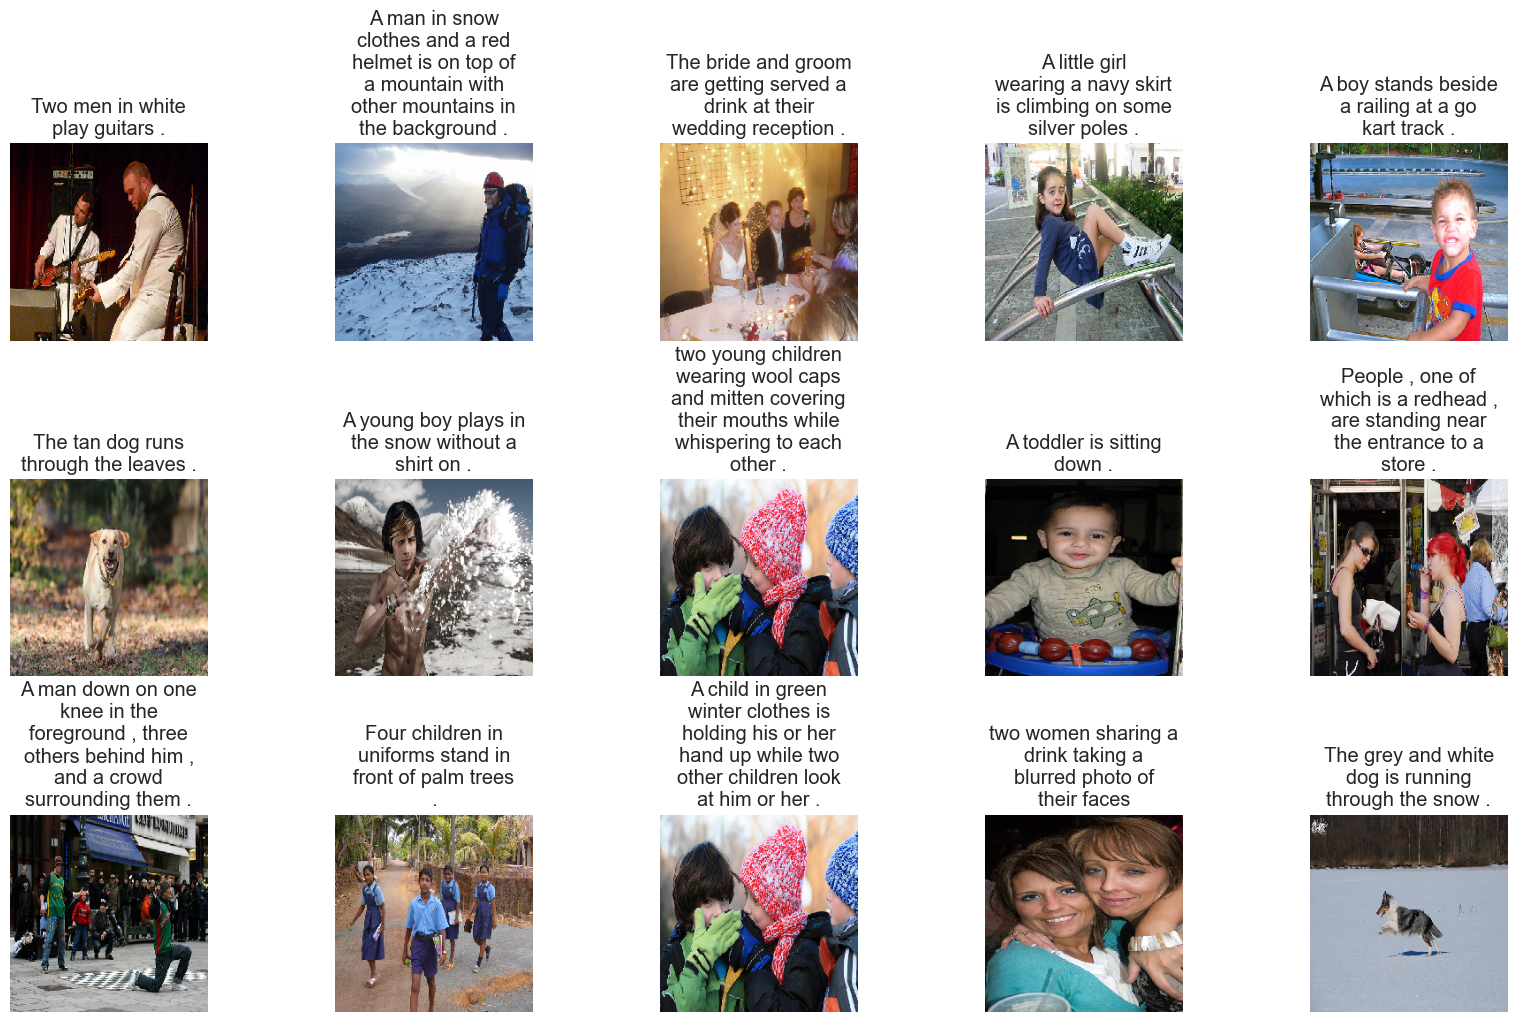

In [8]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [9]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [10]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

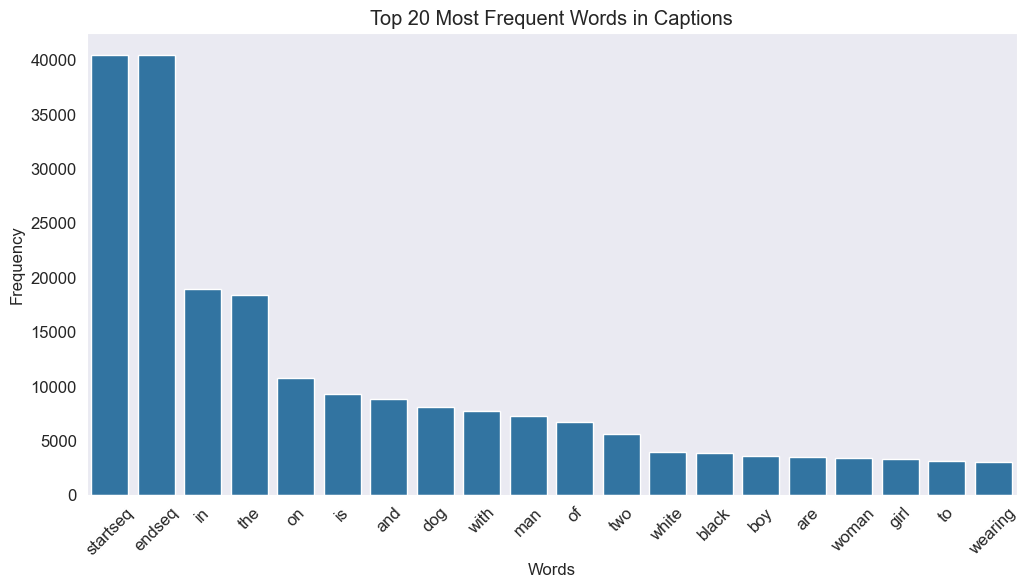

In [12]:
from collections import Counter

# Analyze word frequencies
word_counts = Counter(" ".join(captions).split())
most_common_words = word_counts.most_common(20)

# Plot the word frequency distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Frequent Words in Captions")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.xticks(rotation=45)
plt.show()


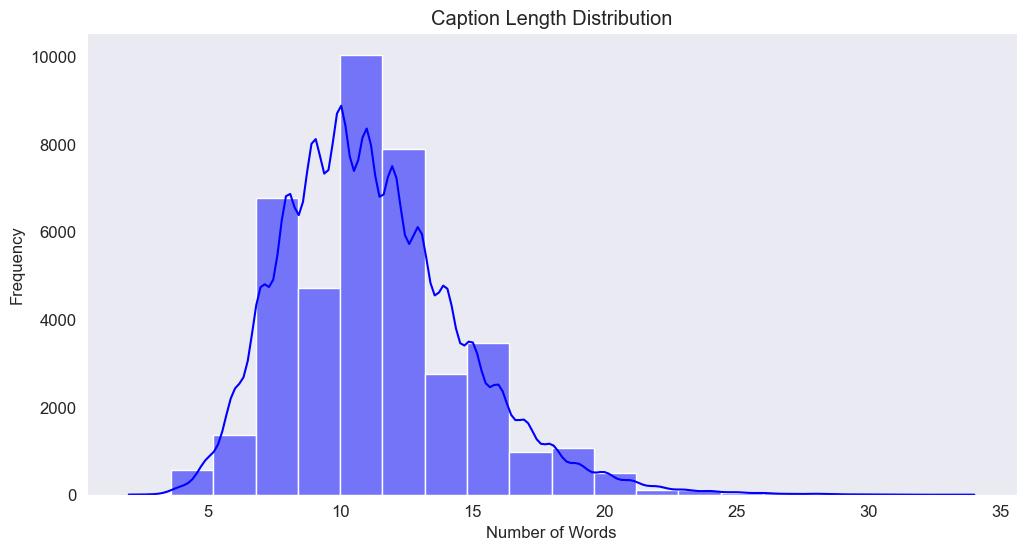

Average Caption Length: 11.229464837473737
Maximum Caption Length: 34
Minimum Caption Length: 2


In [13]:
caption_lengths = [len(caption.split()) for caption in captions]

plt.figure(figsize=(12, 6))
sns.histplot(caption_lengths, bins=20, kde=True, color='blue')
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

print(f"Average Caption Length: {np.mean(caption_lengths)}")
print(f"Maximum Caption Length: {max(caption_lengths)}")
print(f"Minimum Caption Length: {min(caption_lengths)}")


Number of Training Images: 6877
Number of Validation Images: 1214


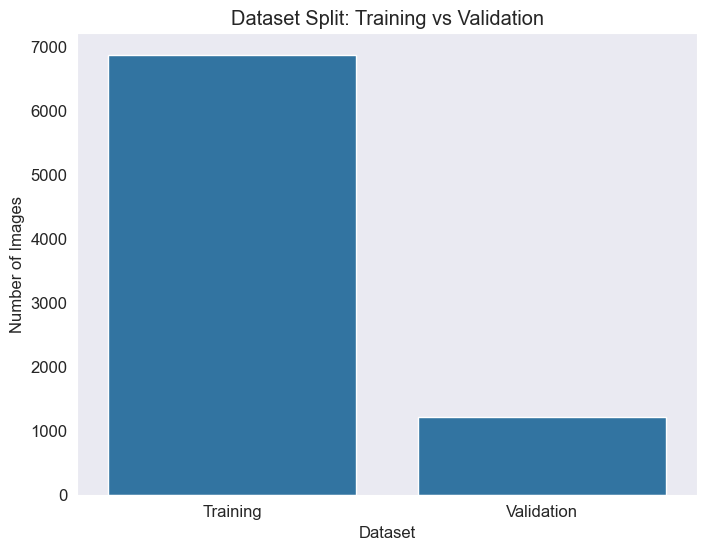

In [14]:
print(f"Number of Training Images: {len(train_images)}")
print(f"Number of Validation Images: {len(val_images)}")

# Plot distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=['Training', 'Validation'], y=[len(train_images), len(val_images)])
plt.title("Dataset Split: Training vs Validation")
plt.ylabel("Number of Images")
plt.xlabel("Dataset")
plt.show()


In [15]:
# Summarize Data Insights
print("=== Data Insights ===")
print(f"Total Number of Captions: {len(captions)}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Average Caption Length: {np.mean(caption_lengths)}")
print(f"Number of Training Images: {len(train_images)}")
print(f"Number of Validation Images: {len(val_images)}")

=== Data Insights ===
Total Number of Captions: 40455
Vocabulary Size: 8485
Average Caption Length: 11.229464837473737
Number of Training Images: 6877
Number of Validation Images: 1214


In [16]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|███████████████████████████████████████| 8091/8091 [12:21<00:00, 10.91it/s]


# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [17]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [18]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [19]:
from tensorflow.keras.utils import plot_model

In [20]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=128,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=128,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)


In [22]:
# model = load_model('model.keras')
# model_name = "model.keras"  # Change from .h5 to .keras
# checkpoint = ModelCheckpoint(model_name,
#                              monitor="val_loss",
#                              mode="min",
#                              save_best_only=True,
#                              verbose=1)
# earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
#                                             patience=3,
#                                             verbose=1,
#                                             factor=0.2,
#                                             min_lr=0.00000001)

In [23]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


model.save('model.keras')
from keras.models import load_model
model = load_model('model.keras')


# Define the callbacks
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)
# After defining the model
caption_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Now you can fit the model
caption_model.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=50,
                  callbacks=[checkpoint, earlystopping, learning_rate_reduction])




Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1138 - loss: 6.0106
Epoch 1: val_loss improved from inf to 4.34253, saving model to model.keras
268/268 ━━━━━━━━━━━━━━━━━━━━ 1032s 4s/step - accuracy: 0.1140 - loss: 6.0079 - val_accuracy: 0.2364 - val_loss: 4.3425 - learning_rate: 0.0010
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.2348 - loss: 4.3637
Epoch 2: val_loss improved from 4.34253 to 4.00391, saving model to model.keras
268/268 ━━━━━━━━━━━━━━━━━━━━ 165s 617ms/step - accuracy: 0.2348 - loss: 4.3634 - val_accuracy: 0.2715 - val_loss: 4.0039 - learning_rate: 0.0010
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.2593 - loss: 4.0476
Epoch 3: val_loss improved from 4.00391 to 3.85438, saving model to model.keras
268/268 ━━━━━━━━━━━━━━━━━━━━ 166s 620ms/step - accuracy: 0.2593 - loss: 4.0475 - val_accuracy: 0.2854 - val_loss: 3.8544 - learning_rate: 0.0010
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.27

In [24]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.3191 - loss: 3.2538
Epoch 1: val_loss did not improve from 3.61476
268/268 ━━━━━━━━━━━━━━━━━━━━ 170s 635ms/step - accuracy: 0.3191 - loss: 3.2537 - val_accuracy: 0.3204 - val_loss: 3.6173 - learning_rate: 2.0000e-04
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.3242 - loss: 3.2151
Epoch 2: val_loss did not improve from 3.61476
268/268 ━━━━━━━━━━━━━━━━━━━━ 169s 632ms/step - accuracy: 0.3242 - loss: 3.2151 - val_accuracy: 0.3211 - val_loss: 3.6167 - learning_rate: 2.0000e-04
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.3239 - loss: 3.2039
Epoch 3: val_loss did not improve from 3.61476
268/268 ━━━━━━━━━━━━━━━━━━━━ 170s 633ms/step - accuracy: 0.3239 - loss: 3.2039 - val_accuracy: 0.3223 - val_loss: 3.6204 - learning_rate: 2.0000e-04
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.3261 - loss: 3.1862
Epoch 4: val_loss did not improve from 3.61476
268/268 ━━━━━

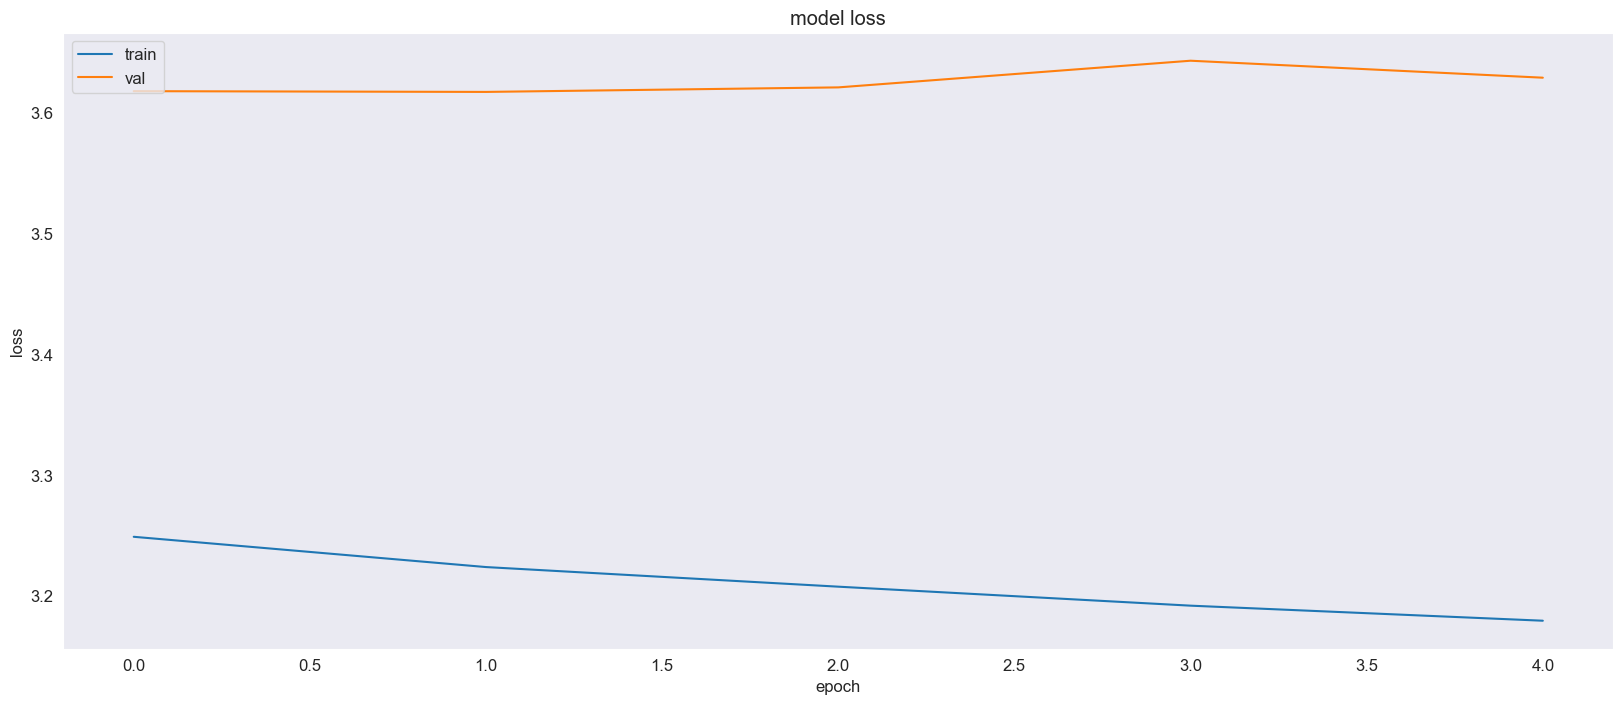

In [25]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [27]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

## **Taking 15 Random Samples for Caption Prediction**

In [28]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [29]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

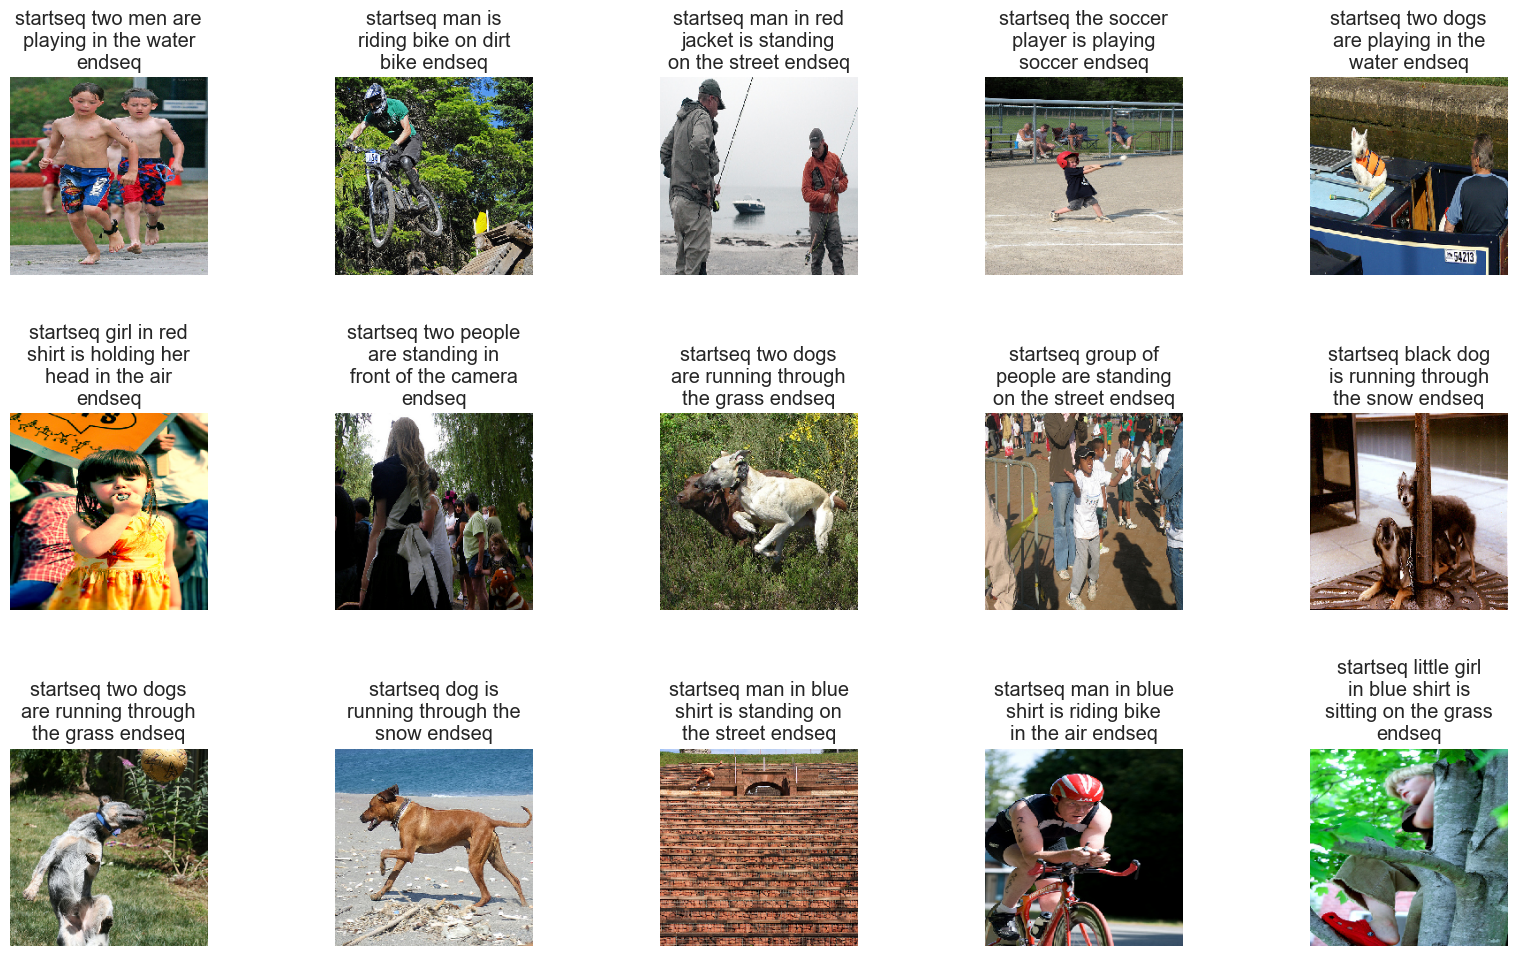

In [30]:
display_images(samples)